# UDBHAV GUPTA


### Data
Using data from : https://www.kaggle.com/netflix-inc/netflix-prize-data/data
It contains:
1. combined_data_1.txt
2. combined_data_2.txt
3. combined_data_3.txt
4. combined_data_4.txt
5. movie_titles.csv

### Data Overview
The first line of each file combined_data_{i}.txt contains the movie id followed by a colon. Each subsequent line in the file corresponds to a rating from a customer and its date in the format: CustomerID,Rating,Date

- MovieIDs range from 1 to 17770 sequentially.
- CustomerIDs range from 1 to 2649429, with gaps. There are 480189 users.
- Ratings are on a five star (integral) scale from 1 to 5.
- Dates have the format YYYY-MM-DD.

In [1]:
# this is just to know how much time will it take to run this entire ipython notebook 
from datetime import datetime

In [2]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('nbagg')

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

import seaborn as sns
sns.set_style('whitegrid')
import os
from scipy import sparse
from scipy.sparse import csr_matrix

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

# Exploratory Data Analysis
### Converting entire data to following format:
u_i,m_j,r_ij

In [3]:
start = datetime.now()
if not os.path.isfile('data.csv'):
    # Create a file 'data.csv' before reading it
    # Read all the files in Netflix Prize Data and store them in one big file('data.csv')
    # I am Re-reading from each of the four files and appendig each rating to a global file 'train.csv'
    data = open('data.csv', mode='w')
    
    row = list()
    files=['data/combined_data_1.txt','data/combined_data_2.txt', 
           'data/combined_data_3.txt', 'data/combined_data_4.txt']
    for file in files:
        print("Reading ratings from {}...".format(file))
        with open(file) as f:
            for line in f: 
                del row[:] # you don't have to do this.
                line = line.strip()
                if line.endswith(':'):
                    # All below are ratings for this movie, until another movie appears.
                    movie_id = line.replace(':', '')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0, movie_id)
                    data.write(','.join(row))
                    data.write('\n')
        print("Done.\n")
    data.close()
print('Time taken :', datetime.now() - start)

Time taken : 0:00:00.001001


In [4]:
loaded_data=pd.read_csv('data.csv')
loaded_data.head()

,1,1488844,3,2005-09-06
0,1,822109,5,2005-05-13
1,1,885013,4,2005-10-19
2,1,30878,4,2005-12-26
3,1,823519,3,2004-05-03
4,1,893988,3,2005-11-17


In [5]:
print("Creating a dataframe fromm data.csv file....")
df=pd.read_csv('data.csv', sep=',',names=['movie','user','rating','date'])
df.date=pd.to_datetime(df.date)
print('Done.\n')

print('Sorting by date')
df.sort_values(by='date',inplace=True)
print('Done')

Creating a dataframe fromm data.csv file....
Done.

Sorting by date
Done


In [7]:
df.shape

(100480103, 4)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100480103 entries, 20393918 to 43733910
Data columns (total 4 columns):
 #   Column  Dtype         
---  ------  -----         
 0   movie   int64         
 1   user    int64         
 2   rating  int64         
 3   date    datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 3.7 GB


In [9]:
df.head()

,movie,user,rating,date
20393918,3870,510180,2,1999-11-11
46516889,8357,510180,4,1999-11-11
68725149,12473,510180,5,1999-11-11
68629646,12470,510180,2,1999-11-11
30518877,5571,510180,4,1999-11-11


In [10]:
df.describe()['rating']

count    1.004801e+08
mean     3.604293e+00
std      1.085218e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

### Checking for NaN values

In [26]:
print("Number of Nan values in our dataframe : ", sum(df.isnull().any()))

Number of Nan values in our dataframe :  0


### Deleting Duplicates either movie_id, user/customer_id, ratings, date

In [27]:
dup_bool = df.duplicated(['movie','user','rating'])
dups = sum(dup_bool) 
print("There are {} duplicate rating entries in the data..".format(dups))

There are 0 duplicate rating entries in the data..


### Number of Users, movies and ratings in sorted_data.csv

In [28]:
print("Total No of Users   :", len(np.unique(df.user)))
print("Total No of movies  :", len(np.unique(df.movie)))
print("Total no of ratings :",df.shape[0]) #total rows == no. of ratings

Total No of Users   : 480189
Total No of movies  : 17770
Total no of ratings : 100480103


### Spliting data into Train and Test (0.80 : 0.20 respectively)

In [6]:
if not os.path.isfile('train.csv'):
    # create the dataframe and store it as csv for further purposes
    df.iloc[:int(df.shape[0]*0.80)].to_csv("train.csv", index=False)
    print("train.csv formed.")
else :
    print("train.csv exists")

if not os.path.isfile('test.csv'):
    # create the dataframe and store it as csv for further purposes
    df.iloc[int(df.shape[0]*0.80):].to_csv("test.csv", index=False)
    print("test.csv formed.")
else :
    print("test.csv exists")

start = datetime.now()
train_df = pd.read_csv("train.csv", parse_dates=['date'])
test_df = pd.read_csv("test.csv")
print("read both csv")
print('Time taken :', datetime.now() - start)


train.csv exists
test.csv exists
read both csv
Time taken : 0:00:35.296739


In [12]:
train_df.head()

,movie,user,rating,date
0,3870,510180,2,1999-11-11
1,8357,510180,4,1999-11-11
2,12473,510180,5,1999-11-11
3,12470,510180,2,1999-11-11
4,5571,510180,4,1999-11-11


### Number of Users, Movies and ratings in train.csv and test.csv

In [32]:
print("Numbers for train.csv")
print("Total No of Users   :", len(np.unique(train_df.user)))
print("Total No of movies  :", len(np.unique(train_df.movie)))
print("Total no of ratings :",train_df.shape[0])

print("\nNumbers for test.csv")
print("Total No of Users   :", len(np.unique(test_df.user)))
print("Total No of movies  :", len(np.unique(test_df.movie)))
print("Total no of ratings :",test_df.shape[0])

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.Numbers for train.csv

Total No of Users   : 405026
Total No of movies  : 17423
Total no of ratings : 80384082

Numbers for test.csv
Total No of Users   : 349316
Total No of movies  : 17757
Total no of ratings : 20096021


### EDA on trian_df

In [7]:
# method to make y-axis more readable
def human(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"

In [14]:
#Rating Distribution ploting was taking very long time

fig, ax = plt.subplots()
plt.title('Distribution of ratings over Training dataset', fontsize=15)
sns.countplot(train_df.rating)
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
ax.set_ylabel('No. of Ratings(Millions)')

#plt.savefig('img/rating-distribution-train_df')

C:\ana py\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\91810\AppData\Local\Temp\ipykernel_16248\2166668588.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])


Text(0, 0.5, 'No. of Ratings(Millions)')

<IPython.core.display.Javascript object>


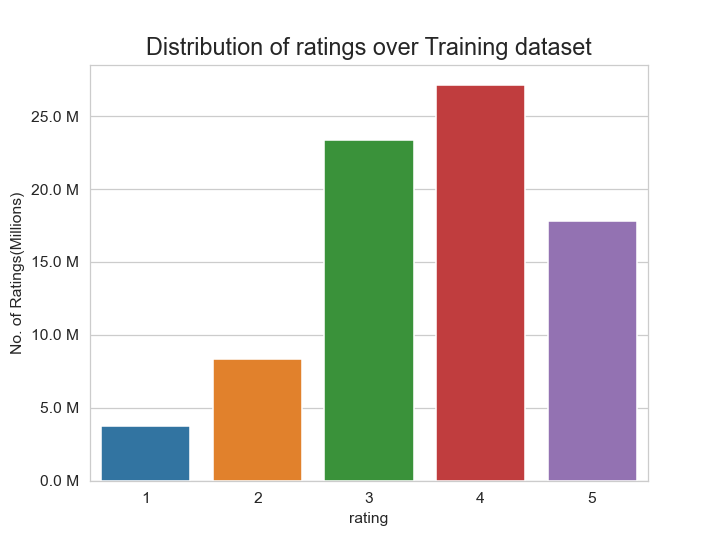

Distribution of ratings over Training dataset:
4    27160741
3    23339530
5    17772020
2     8370270
1     3741521
Name: rating, dtype: int64
Time taken: 0:00:01.682389


In [15]:
plt.show()
start = datetime.now()
rating_counts = train_df['rating'].value_counts()
print("Distribution of ratings over Training dataset:")
print(rating_counts)
print('Time taken:', datetime.now() - start)

In [8]:
# # Add new column (week day) to the data
# train_df['day_of_week'] = train_df.date.dt.weekday_name
# train_df.head()

# Add new column (week day) to the data
train_df['day_of_week'] = train_df['date'].dt.day_name()
train_df.head()

,movie,user,rating,date,day_of_week
0,3870,510180,2,1999-11-11,Thursday
1,8357,510180,4,1999-11-11,Thursday
2,12473,510180,5,1999-11-11,Thursday
3,12470,510180,2,1999-11-11,Thursday
4,5571,510180,4,1999-11-11,Thursday


In [9]:
avg_week_df = train_df.groupby(by=['day_of_week'])['rating'].mean()
print("Average ratings")
print(avg_week_df)

Average ratings
day_of_week
Friday       3.585278
Monday       3.576969
Saturday     3.591795
Sunday       3.594146
Thursday     3.582467
Tuesday      3.574441
Wednesday    3.583754
Name: rating, dtype: float64


C:\Users\91810\AppData\Local\Temp\ipykernel_16248\3308089118.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])


<IPython.core.display.Javascript object>


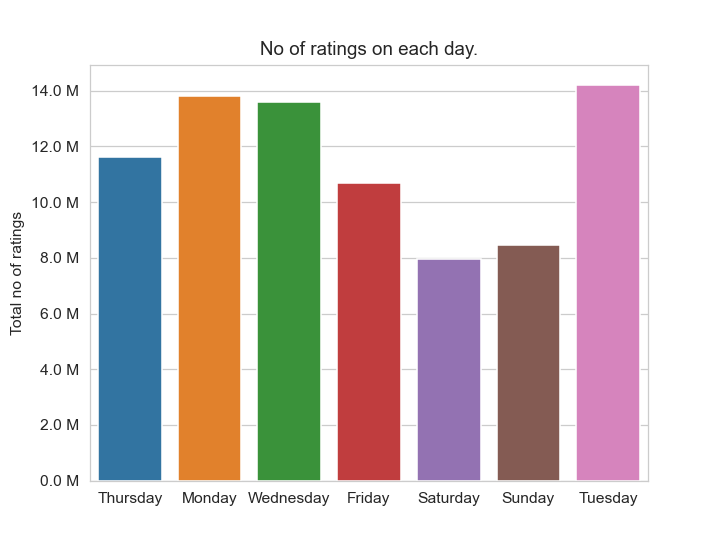

In [18]:
fig, ax = plt.subplots()
sns.countplot(x='day_of_week', data=train_df, ax=ax)
plt.title('No of ratings on each day.')
plt.ylabel('Total no of ratings')
plt.xlabel('')
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show()
#plt.savefig('img/no.-of-rating-on-each-day_of_week-train_df.png')

C:\Users\91810\AppData\Local\Temp\ipykernel_16248\3143141947.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])


<IPython.core.display.Javascript object>


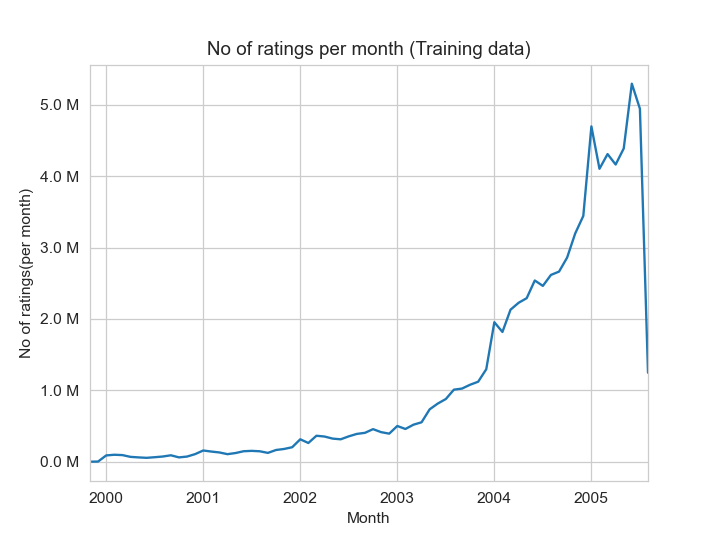

In [19]:
ax = train_df.resample('m', on='date')['rating'].count().plot()
ax.set_title('No of ratings per month (Training data)')
plt.xlabel('Month')
plt.ylabel('No of ratings(per month)')
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show()
#plt.savefig('img/no.-of-ratings-per-month-train_df.png')

### Analysis on ratings given by a user

In [8]:
no_of_rated_movies_per_user = train_df.groupby(by='user')['rating'].count().sort_values(ascending=False)
no_of_rated_movies_per_user.head()

user
305344     17110
2439493    15896
387418     15402
1639792     9767
1461435     9447
Name: rating, dtype: int64

<IPython.core.display.Javascript object>


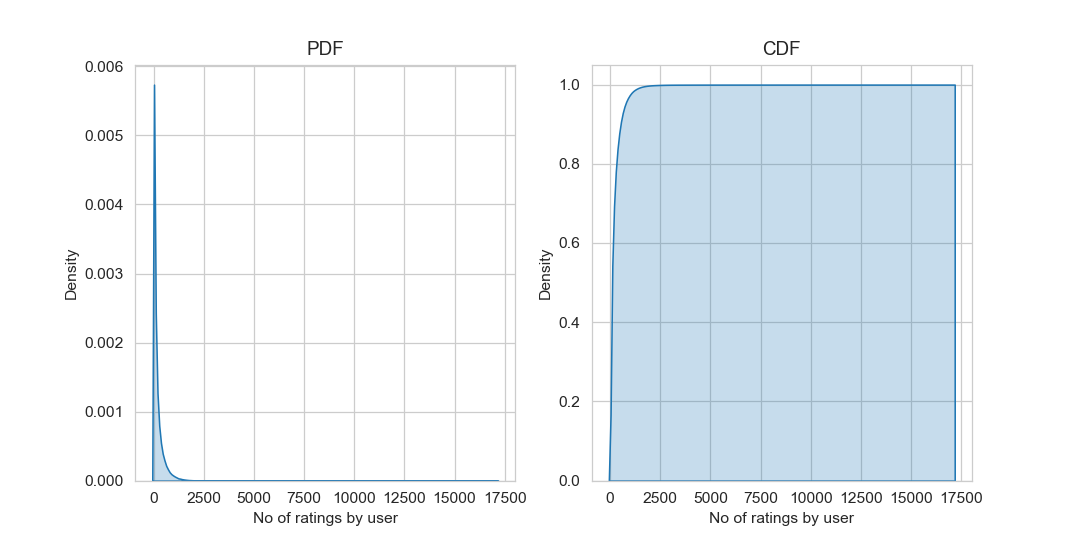

In [21]:
fig = plt.figure(figsize=plt.figaspect(.5))

ax1 = plt.subplot(121)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, ax=ax1)
plt.xlabel('No of ratings by user')
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, cumulative=True,ax=ax2)
plt.xlabel('No of ratings by user')
plt.title('CDF')
plt.show()
#plt.savefig('img/pdf-cdf-rating-by-user-train_df.png')

Above warning is just about to use "fill" in place of "shade"

In [22]:
no_of_rated_movies_per_user.describe()

count    405026.000000
mean        198.466474
std         290.800128
min           1.000000
25%          34.000000
50%          89.000000
75%         245.000000
max       17110.000000
Name: rating, dtype: float64

In [23]:
quantiles = no_of_rated_movies_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')
quantiles

0.00        1
0.01        1
0.02        2
0.03        4
0.04        5
        ...  
0.96      829
0.97      934
0.98     1079
0.99     1341
1.00    17110
Name: rating, Length: 101, dtype: int64

<IPython.core.display.Javascript object>


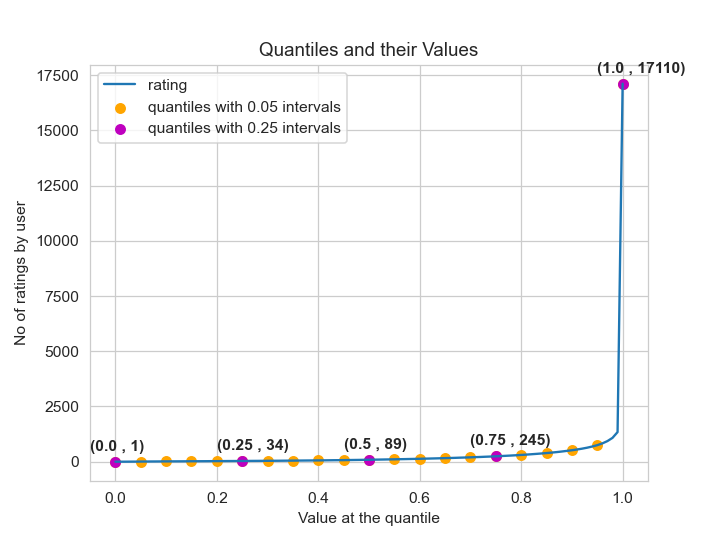

In [24]:
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')

# annotate the 25th, 50th, 75th and 100th percentile values....
for x,y in zip(quantiles.index[::25], quantiles[::25]):
    s= s="({} , {})".format(x,y)
    plt.annotate(s, xy=(x,y), xytext=(x-0.05, y+500)
                ,fontweight='bold')

plt.show()
#plt.savefig('img/quantiles.png')

In [25]:
quantiles[::5]

0.00        1
0.05        7
0.10       15
0.15       21
0.20       27
0.25       34
0.30       41
0.35       50
0.40       60
0.45       73
0.50       89
0.55      109
0.60      133
0.65      163
0.70      199
0.75      245
0.80      307
0.85      392
0.90      520
0.95      749
1.00    17110
Name: rating, dtype: int64

<IPython.core.display.Javascript object>


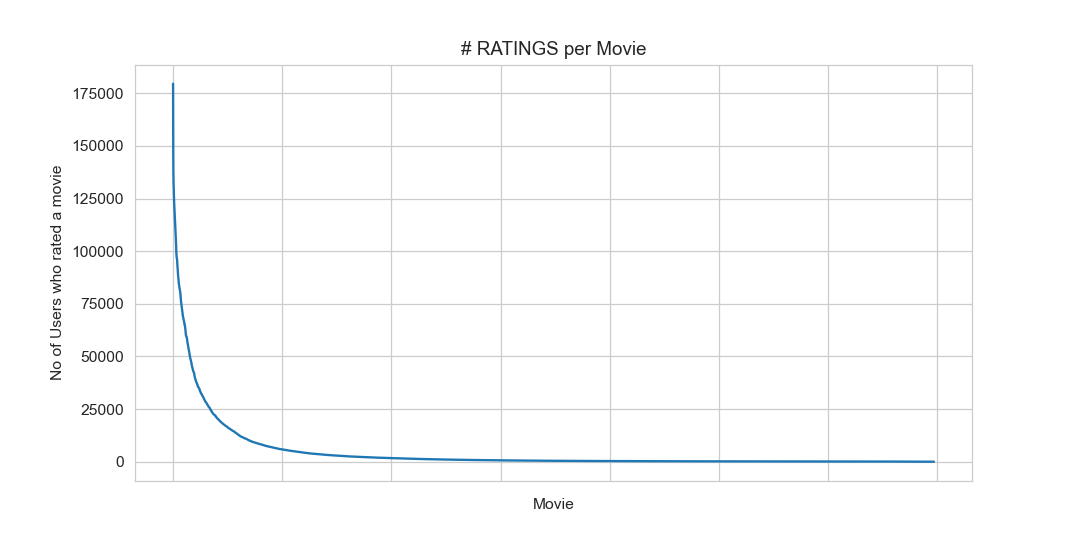

In [26]:
no_of_ratings_per_movie = train_df.groupby(by='movie')['rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_movie.values)
plt.title('# RATINGS per Movie')
plt.xlabel('Movie')
plt.ylabel('No of Users who rated a movie')
ax.set_xticklabels([])

#plt.savefig('img/per-movie-ratings-train_df.png')
plt.show()

- There are some (<10%) movies which are rated by huge number of users.
- But majority movies exists which are rated by some hundereds of users. 

## Building sparse matrices from data

- Present data has 4 columns, user, movie, ratings and date; for each movie there are many users and each user gives rating.
- This takes lot of memory.
- To minimize usage of memory, I am creating two arrays, one for movies(m_i's) and one for users(u_j's), by some matrix operation (generally dot product) would give me rating (r_ij's)

In [9]:
start = datetime.now()
if os.path.isfile('train_sparse_matrix.npz'):
    print("It is present in pwd, loading it")
    train_sparse_matrix = sparse.load_npz('train_sparse_matrix.npz')
    print('Done. It\'s shape is : (user, movie) : ',train_sparse_matrix.shape)
else: 
    print("Building sparse_matrix from the dataframe...")
    # create sparse_matrix and store it for after usage.
    # csr_matrix(data_values, (row_index, col_index), shape_of_matrix)
    # It should be in such a way that, MATRIX[row, col] = data
    train_sparse_matrix = sparse.csr_matrix((train_df.rating.values, (train_df.user.values,
                                               train_df.movie.values)),)
    
    print('Done. It\'s shape is : (user, movie) : ',train_sparse_matrix.shape)
    print('Saving it into pwd for further usages...')

    sparse.save_npz("train_sparse_matrix.npz", train_sparse_matrix)
    print('Done.\n')

print(datetime.now() - start)

It is present in pwd, loading it
Done. It's shape is : (user, movie) :  (2649430, 17771)
0:00:02.283539


In [10]:
start = datetime.now()
if os.path.isfile('test_sparse_matrix.npz'):
    print("It is present in pwd, loading it.")
    test_sparse_matrix = sparse.load_npz('test_sparse_matrix.npz')
    print('Done. It\'s shape is : (user, movie) : ',test_sparse_matrix.shape)
else: 
    print("Building sparse_matrix from the dataframe...")
    # create sparse_matrix and store it for after usage.
    # csr_matrix(data_values, (row_index, col_index), shape_of_matrix)
    # It should be in such a way that, MATRIX[row, col] = data
    test_sparse_matrix = sparse.csr_matrix((test_df.rating.values, (test_df.user.values,
                                               test_df.movie.values)))
    
    print('Done. It\'s shape is : (user, movie) : ',test_sparse_matrix.shape)
    print('Saving it into pwd for further usages...')

    sparse.save_npz("test_sparse_matrix.npz", test_sparse_matrix)
    print('Done.')
    
print(datetime.now() - start)

It is present in pwd, loading it.
Done. It's shape is : (user, movie) :  (2649430, 17771)
0:00:00.612285


### Sparsity = (Number of Zero enteries/Number of total enteries)*100

In [11]:
us,mv = train_sparse_matrix.shape
elem = train_sparse_matrix.count_nonzero()
print("Sparsity Of Train matrix : {} % ".format((1-(elem/(us*mv)))*100))

Sparsity Of Train matrix : 99.82927161194176 % 


In [12]:
us,mv = test_sparse_matrix.shape
elem = test_sparse_matrix.count_nonzero()
print("Sparsity Of Test matrix : {} % ".format(  (1-(elem/(us*mv))) * 100) )

Sparsity Of Test matrix : 99.95731790192349 % 


### Calculating Average rating globally, per movie and per user

In [13]:
def get_average_ratings(sparse_matrix, of_users):  # of_users is boolean flag (1: users, 0:movies)
    
    # selecting axes of sparse matrix
    ax = 1 if of_users else 0
    
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1     # ".A1" for converting Column_Matrix to 1-D numpy array 
    
    # Boolean matrix of ratings (whether a user rated that movie or not)
    is_rated = sparse_matrix!=0
    
    # no of ratings that each user OR movie..
    no_of_ratings = is_rated.sum(axis=ax).A1
    
    u,m = sparse_matrix.shape     # max_user(u)  and max_movie(m) id's in sparse matrix 

    # average_rating = sum of ratings/sum of non-zero entries
    average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i]            
                                 for i in range(u if of_users else m) 
                                    if no_of_ratings[i] !=0}  
    
    return average_ratings # returns dict

In [14]:
train_averages = dict()

train_global_average = train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
train_averages['global'] = train_global_average
print(f"Global Average of Ratings in training data is {train_averages}")


Global Average of Ratings in training data is {'global': 3.582845108562663}


In [15]:
train_averages['user'] = get_average_ratings(train_sparse_matrix, of_users=True)
# user = random.randint(1,train_sparse_matrix.shape [0])
# print(user)

# Generate a random user ID within the valid range
valid_users = list(train_averages['user'].keys())  # Get the list of valid user IDs
user = random.choice(valid_users) 
print(f'Average rating of user {user} :',train_averages['user'][user])

Average rating of user 2378282 : 3.1310344827586207


In [16]:
train_averages['movie'] =  get_average_ratings(train_sparse_matrix, of_users=False)

valid_movies = list(train_averages['movie'].keys())
movie = random.choice(valid_movies)
print(f'Average rating of movie {movie} :',train_averages['movie'][movie])

Average rating of movie 6632 : 3.4144725370531823


PDF and CDF of avg rating of user and movie in train_df

<IPython.core.display.Javascript object>


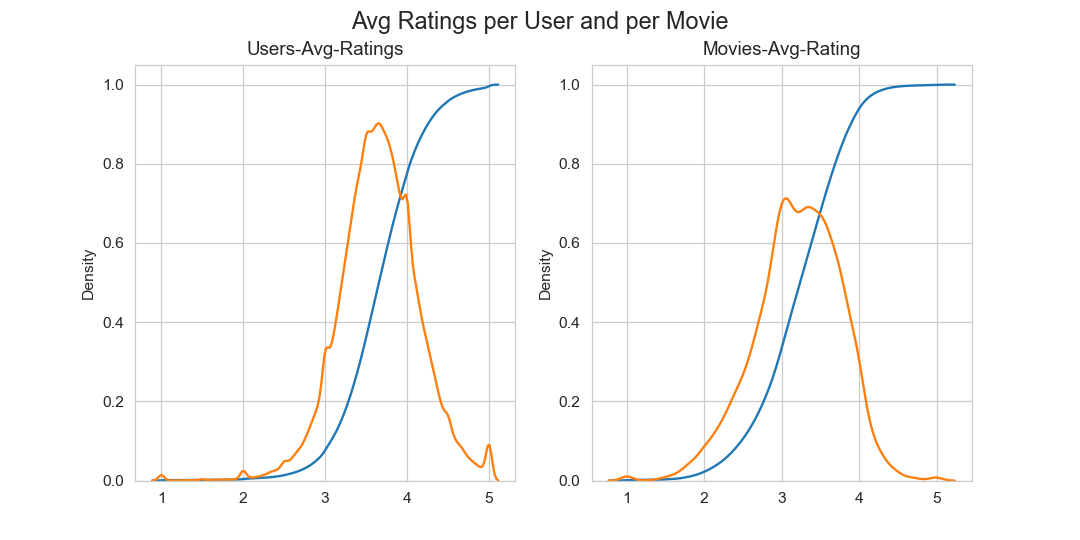

0:00:10.817449


In [17]:
start = datetime.now()

# Draw PDFs for average rating per user and per movie
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(.5))
fig.suptitle('Avg Ratings per User and per Movie', fontsize=15)

ax1.set_title('Users-Avg-Ratings')
# Get the list of average user ratings from the averages dictionary
user_averages = [rat for rat in train_averages['user'].values()]
sns.kdeplot(user_averages, cumulative=True, ax=ax1, label='Cdf')
sns.kdeplot(user_averages, ax=ax1, label='Pdf')

ax2.set_title('Movies-Avg-Rating')
# Get the list of movie average ratings from the dictionary
movie_averages = [rat for rat in train_averages['movie'].values()]
sns.kdeplot(movie_averages, cumulative=True, ax=ax2, label='Cdf')
sns.kdeplot(movie_averages, ax=ax2, label='Pdf')

plt.show()
#plt.savefig('img/pdf-cdf-avg-rating-user&movie.png')
print(datetime.now() - start)

### How many new users and movies would I encounter in test_csv ?

In [36]:
total_users = len(np.unique(df.user))
users_train = len(train_averages['user'])
new_users = total_users - users_train

print('Total number of Users  :', total_users)
print('Number of Users in Train data :', users_train)
print("No of Users that didn't appear in train data: {} ({} %) \n ".format(new_users,(new_users/total_users)*100))

Total number of Users  : 480189
Number of Users in Train data : 405026
No of Users that didn't appear in train data: 75163 (15.652795045284254 %) 
 


In [37]:
total_movies = len(np.unique(df.movie))
movies_train = len(train_averages['movie'])
new_movies = total_movies - movies_train

print('Total number of Movies  :', total_movies)
print('Number of Users in Train data :', movies_train)
print("No of Movies that didn't appear in train data: {} ({} %) \n ".format(new_movies,(new_movies/total_movies)*100))

Total number of Movies  : 17770
Number of Users in Train data : 17423
No of Movies that didn't appear in train data: 347 (1.9527293190770962 %) 
 


# Computing similarity matrix

### user - user collaborative filtering

In [18]:
from sklearn.metrics.pairwise import cosine_similarity


def compute_user_similarity(sparse_matrix, compute_for_few=False, top = 100, verbose=False, verb_for_n_rows = 20,
                            draw_time_taken=True):
    no_of_users = sparse_matrix.shape[0]
    # get the indices of  non zero rows (users) from our sparse matrix
    row_ind, col_ind = sparse_matrix.nonzero()
    row_ind = sorted(set(row_ind)) 
    time_taken = list() #  time taken for finding similar users for an user
    
    # Create rows, cols, and data lists.., which can be used to create sparse matrices
    rows, cols, data = list(), list(), list()
    if verbose: print("Computing strted for top",top,"similarities for each user...")
    
    start = datetime.now()
    temp = 0
    
    for row in row_ind[:top] if compute_for_few else row_ind:
        temp = temp+1
        prev = datetime.now()
        
        # get the similarity row for this user with all other users
        sim = cosine_similarity(sparse_matrix.getrow(row), sparse_matrix).ravel()
        # I will consider only the top 10/20/40/100 etc  most similar users and ignore rest of them..
        top_sim_ind = sim.argsort()[-top:]
        top_sim_val = sim[top_sim_ind]
        
        # add them to our rows, cols and data
        rows.extend([row]*top)
        cols.extend(top_sim_ind)
        data.extend(top_sim_val)
        time_taken.append(datetime.now().timestamp() - prev.timestamp())
        if verbose:
            if temp%verb_for_n_rows == 0:
                print("Computing done for {} users [  time elapsed : {}  ]"
                      .format(temp, datetime.now()-start))
            
        
    # lets create sparse matrix out of these and return it
    if verbose: print('Creating Sparse matrix from the computed similarities')
    #return rows, cols, data
    
    if draw_time_taken:
        plt.plot(time_taken, label = 'time taken for each user')
        plt.plot(np.cumsum(time_taken), label='Total time')
        plt.legend(loc='best')
        plt.xlabel('User')
        plt.ylabel('Time (seconds)')
        plt.savefig('img/u-u-cf-17k-dim-per-user.png')
        
    return sparse.csr_matrix((data, (rows, cols)), shape=(no_of_users, no_of_users)), time_taken 

In [70]:
##Takes time to execute

start = datetime.now()
u_u_sim_sparse, _ = compute_user_similarity(train_sparse_matrix, compute_for_few=True, top = 200,
                                                     verbose=True)
print("Time taken for user-user cf with 17k dimensions per user :",datetime.now()-start)

Computing strted for top 200 similarities for each user...
Computing done for 20 users [  time elapsed : 0:00:52.440494  ]
Computing done for 40 users [  time elapsed : 0:01:47.396291  ]
Computing done for 60 users [  time elapsed : 0:02:38.359816  ]
Computing done for 80 users [  time elapsed : 0:03:31.072717  ]
Computing done for 100 users [  time elapsed : 0:04:26.068623  ]
Computing done for 120 users [  time elapsed : 0:05:22.991640  ]
Computing done for 140 users [  time elapsed : 0:06:14.801659  ]
Computing done for 160 users [  time elapsed : 0:07:09.073325  ]
Computing done for 180 users [  time elapsed : 0:08:01.786251  ]
Computing done for 200 users [  time elapsed : 0:08:56.131036  ]
Creating Sparse matrix from the computed similarities
Time taken for user-user cf with 17k dimensions per user : 0:09:00.442480


- Calculating user-user Similarity_Matrix (user-user collaborative filtering) is not an easy task
- For top 200 users it took **0:09:13.713449** time, and as users count increases, complexity increases as one could find more and more similarities. 

* On avg per time consumed for searching similarity for one user = (9*60 + 13.71)/200 = **2.76 seconds**
* training data have 405041 users, so approximately it would take **405041*2.76 = 1117913 seconds = 12.93 days**
* It will take almost **13** days to just find similarities !

- Hence, i would try to find user-user similarity via reduced dimensions

### Truncated SVD for reducing the dimesnion of user vector
- SVD basically is a factorization of that matrix into three smaller matrices.
- The SVD of mxn matrix A is given by the formula A = U Σ V^T 
- Where
   - U is m*m matrix of orthonormal eigen vectors of AA^T
   - V^T is n*n matrix of orthonormal eigen vectors of (A^T)A
   - Σ is diagonal matrix with r elements, r = square root of positive eigen values of AA^T (or (A^T)A)

In [77]:
#Takes Time

from datetime import datetime
from sklearn.decomposition import TruncatedSVD

start = datetime.now()

# All parameters are default except n_components. n_itr is for Randomized SVD solver.
netflix_svd = TruncatedSVD(n_components=100, algorithm='randomized', random_state=42)
print("Fitting started...")
trunc_svd = netflix_svd.fit_transform(train_sparse_matrix)

num_iterations = 10
for i in range(num_iterations):
    # Fit the TruncatedSVD model for each iteration
    trunc_svd = netflix_svd.fit_transform(train_sparse_matrix)
    
    # Print progress update
    print(f"Iteration {i+1}/{num_iterations} completed")

print(datetime.now()-start)

Fitting started...
Iteration 1/10 completed
Iteration 2/10 completed
Iteration 3/10 completed
Iteration 4/10 completed
Iteration 5/10 completed
Iteration 6/10 completed
Iteration 7/10 completed
Iteration 8/10 completed
Iteration 9/10 completed
Iteration 10/10 completed
0:37:45.080744


In [79]:
expl_var = np.cumsum(netflix_svd.explained_variance_ratio_)
expl_var

array([0.23361595, 0.26270184, 0.28322758, 0.29935554, 0.31128909,
       0.32271716, 0.33167664, 0.33815579, 0.34419839, 0.34937796,
       0.35411383, 0.35789098, 0.36144361, 0.36479436, 0.36794886,
       0.37095254, 0.37379387, 0.37652408, 0.37890613, 0.38126788,
       0.38354054, 0.38571574, 0.38785532, 0.38994931, 0.39199664,
       0.39391637, 0.39575229, 0.39752102, 0.39922974, 0.40090096,
       0.40249586, 0.40406281, 0.40561301, 0.40713464, 0.40862472,
       0.41007315, 0.41149788, 0.41289648, 0.41426359, 0.41560189,
       0.41690654, 0.41817027, 0.41939685, 0.4206115 , 0.42181611,
       0.42299196, 0.42415403, 0.42528757, 0.42640547, 0.42751714,
       0.42860914, 0.42968049, 0.43072899, 0.43176015, 0.43278979,
       0.43380377, 0.4348037 , 0.43578136, 0.43675524, 0.43771334,
       0.43866033, 0.43959903, 0.44052363, 0.44143143, 0.44233904,
       0.44323193, 0.4441138 , 0.44499139, 0.44585449, 0.4467072 ,
       0.4475548 , 0.44839173, 0.44921896, 0.45004103, 0.45084

- It basically is the gain of variance explained, if we add one additional latent factor to it via np.cumsum()
- By adding one by one latent factore to it, __gain in explained variance__ is decreasing.
- To take it to greter than 0.60, we have to take almost 400-500+ latent factors. It's totally useless (more compute power and memory loss)

<IPython.core.display.Javascript object>


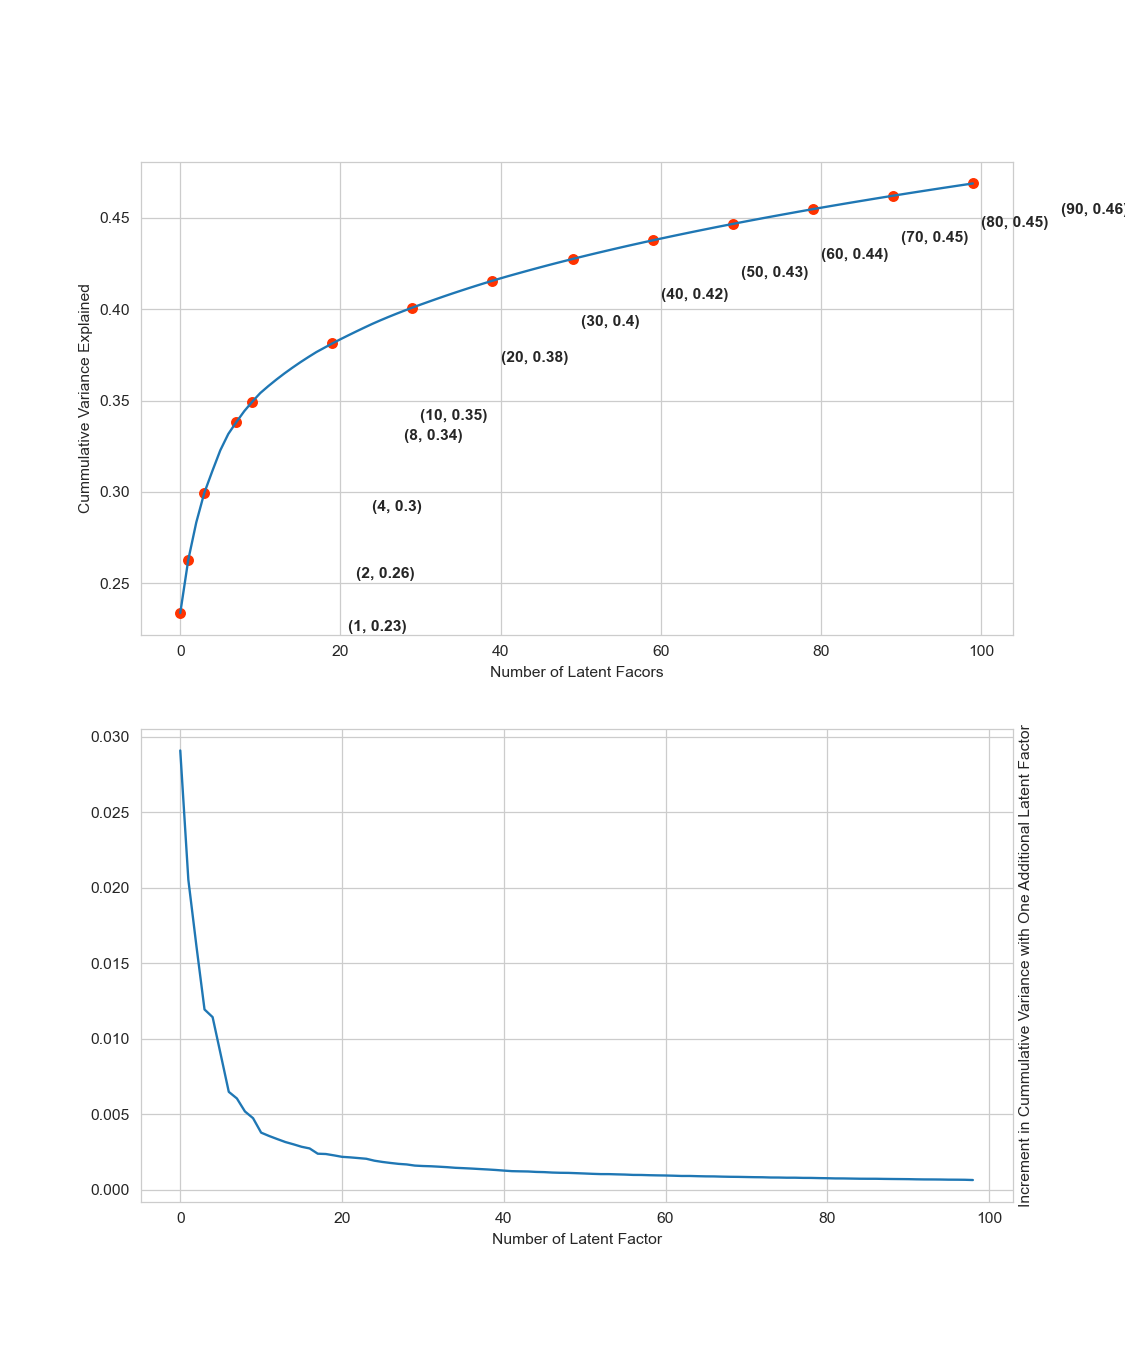

In [80]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

ax1.set_ylabel("Cummulative Variance Explained")
ax1.set_xlabel("Number of Latent Facors")
ax1.plot(expl_var)
# annote some (latentfactors, expl_var) to make it clear
ind = [1, 2, 4, 8, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
ax1.scatter(x = [i-1 for i in ind], y = expl_var[[i-1 for i in ind]], c='#ff3300')
for i in ind:
    ax1.annotate("({}, {})".format(i, np.round(expl_var[i-1], 2)), xy=(i-1, expl_var[i-1]),
                xytext = ( i+20, expl_var[i-1] - 0.01),fontweight='bold')

change_in_expl_var = [expl_var[i+1] - expl_var[i] for i in range(len(expl_var)-1)]
ax2.plot(change_in_expl_var)

ax2.set_ylabel("Increment in Cummulative Variance with One Additional Latent Factor", fontsize=10)
ax2.yaxis.set_label_position("right")
ax2.set_xlabel("Number of Latent Factor")

plt.show()
#plt.savefig('img/netflix_svd-expl-var.png')

We are not getting benifitted from adding one latent factor each time. This is what is shown in the plots (specially the bottom plot, it gets almost flatten after that knee).

In [21]:
for i in ind:
    print("({}, {})".format(i, np.round(expl_var[i-1], 2)))

NameError: name 'ind' is not defined

In [82]:
# Project Original U_M matrix into into 100 Dimensional space...
start = datetime.now()
trunc_matrix = train_sparse_matrix.dot(netflix_svd.components_.T)
print(datetime.now()- start)

0:00:04.138713


In [83]:
type(trunc_matrix), trunc_matrix.shape

(numpy.ndarray, (2649430, 100))

In [84]:
if not os.path.isfile('trunc_sparse_matrix.npz'):
    trunc_sparse_matrix = sparse.csr_matrix(trunc_matrix)
    sparse.save_npz('trunc_sparse_matrix', trunc_sparse_matrix)
else:
    print("trunc_sparse_matrix.npz already exists. Loading it...")
    start = datetime.now()
    trunc_sparse_matrix = sparse.load_npz('trunc_sparse_matrix.npz')
    print(datetime.now()- start)

In [85]:
trunc_sparse_matrix.shape

(2649430, 100)

In [86]:

start = datetime.now()
trunc_u_u_sim_matrix, _ = compute_user_similarity(trunc_sparse_matrix, compute_for_few=True, top=50, verbose=True, 
                                                 verb_for_n_rows=10)

print("time:",datetime.now()-start)

Computing strted for top 50 similarities for each user...
Computing done for 10 users [  time elapsed : 0:00:10.501946  ]
Computing done for 20 users [  time elapsed : 0:00:20.733709  ]
Computing done for 30 users [  time elapsed : 0:00:32.308677  ]
Computing done for 40 users [  time elapsed : 0:00:46.859530  ]
Computing done for 50 users [  time elapsed : 0:01:00.343669  ]
Creating Sparse matrix from the computed similarities
time: 0:01:02.531841


- Time taken per user = 0:00:40.144739 / 50 = **0.802 seconds**
-  We have total users = 405041, which means u-u similarity presize computation would take 405041*0.802 = 4 days approx
- No doubt, svd has decreased the time of computation, but 4+ days time is also a very long time. It would take lot of memory and computation power, which is very very hard to execute.

In [19]:
if not os.path.isfile('u_u_sim_sparse.npz'):
    # Save the computed user-user similarity matrix
    sparse.save_npz("u_u_sim_sparse.npz", trunc_u_u_sim_matrix)
else:
    print("u_u_sim_sparse.npz already exists. Loading it...")
    start = datetime.now()
    u_u_sim_sparse = sparse.load_npz('u_u_sim_sparse.npz')
    print(datetime.now()- start)

u_u_sim_sparse.npz already exists. Loading it...
0:00:00.041102


### Alternative/Modification to traditional SVD
But one drawback i noticed in my above method is, it re-calculate the similarities of a user with another user in some iterations.
To minimize/optimize it:
- I will maintain a binary Vector for users, which tells us whether program has already computed top(say, 100) similarities for a user or not.
-  **If not** : Compute top (say, 100) most similar users for this user, and add this to our datastructure, so that we can just access it(similar users) without recomputing it again. The way which i did above
- But **If It is already Computed** : Just get it directly from our datastructure. In due time,i might have to recompute similarities, if it is computed a long time ago. Because user preferences changes over time. 
- So, program could maintain some kind of **Timer**, which when expires, we have to update it ( recompute it ).





### Impact of Dimensionality Reduction Using Truncated SVD on Computation Time

- **Sparse Matrix Representation**:
    - Initially, our user-item interactions are stored in a sparse matrix format, which is efficient in terms of memory and computational resources. Only non-zero values and their indices are stored, making operations on the matrix faster when many elements are zero.

- **Dimensionality Reduction**:
    - To reduce computational complexity, we apply Truncated SVD to reduce the number of dimensions (features) in our data. This technique helps in simplifying the data structure while retaining most of the information.

- **Dense Matrix After SVD**:
    - Post-SVD, the resulting matrix is dense. Unlike the sparse matrix, a dense matrix stores all elements, including zeros. This change increases memory usage and computational cost, as operations now involve more elements.

- **Impact on Computation Time**:
    - **Initial Sparse Matrix**: Operations on the sparse matrix are efficient due to its storage of only non-zero elements.
    - **After SVD (Dense Matrix)**: Despite the reduced number of dimensions, the dense format leads to increased computational complexity per element, as all elements are now involved in operations.

- **Conclusion**:
    - **Net Effect**: The transformation from a sparse to a dense matrix can negate the computational benefits of dimensionality reduction. Therefore, the overall computation time might remain similar or even increase, despite the reduction in dimensionality.

### Summary
- **Initial Sparse Matrix**: Efficient due to sparsity.
- **Post-SVD Dense Matrix**: Increased computational cost per element due to dense format.
- **Net Impact**: Similar or higher computation times, highlighting the trade-off between dimensionality reduction and matrix sparsity.
"""





### Is there any other way to compute user similarity?

An alternative is to compute similar users for a particular user only when required (i.e., at runtime).

- **On-Demand Similarity Computation**:
    - Maintain a binary vector for users to indicate whether similarity has been computed.
    - **If not computed**:
        - Compute the top N (e.g., 1000) most similar users for the given user.
        - Add this information to the data structure for future access.
    - **If already computed**:
        - Retrieve the similarity data directly from the data structure.

- **Recomputation**:
    - In production, recompute similarities periodically to account for changing user preferences.
    - Use a timer to trigger recomputation when necessary.

- **Data Structure**:
    - The choice of data structure is implementation-dependent.
    - One simple method is to maintain a **Dictionary of Dictionaries**:
        - **Key**: userid
        - **Value**: another dictionary
            - **Key**: similar user
            - **Value**: similarity value



### Movie - Movie collaborative filtering

In [20]:
start = datetime.now()

if not os.path.isfile('m_m_sim_sparse.npz'):
    print("It seems you don't have that file. Computing movie-movie similarity matrix...")
    start = datetime.now()
    
    # Compute the movie-movie similarity matrix
    m_m_sim_sparse = cosine_similarity(X=train_sparse_matrix.T, dense_output=False)
    print("Done..")
    
    # Save the sparse matrix to disk
    print("Saving it to disk without the need of re-computing it again... ")
    sparse.save_npz("m_m_sim_sparse.npz", m_m_sim_sparse)
    print("Done..")
else:
    print("It is there, we will get it.")
    m_m_sim_sparse = sparse.load_npz("m_m_sim_sparse.npz")
    print("Done...")

print("It's a ", m_m_sim_sparse.shape, " dimensional matrix")
print(datetime.now() - start)


It is there, we will get it.
Done...
It's a  (17771, 17771)  dimensional matrix
0:00:27.293188


In [21]:
m_m_sim_sparse.shape

(17771, 17771)

- Even though we have similarity measure of each movie, with all other movies. But generally one don't care much about least similar movies.
- Most of the times platforms recommends only top_xx similar items (here, item = movie). It may be top 10 or 100.
- So, its better to take only top similar movie ratings and store them in a saperate dictionary.

In [22]:
movie_ids = np.unique(m_m_sim_sparse.nonzero()[1])
#movie_ids()

In [23]:
movie_ids

array([    1,     2,     3, ..., 17768, 17769, 17770])

m_m_sim_sparse is based on training dataset, so 0.8*17771 = 17424

In [24]:
start = datetime.now()
similar_movies = dict() 
for movie in movie_ids:
    # get the top similar movies and store them in the dictionary
    sim_movies = m_m_sim_sparse[movie].toarray().ravel().argsort()[::-1][1:]
    similar_movies[movie] = sim_movies[:100]
print(datetime.now() - start)

# just testing similar movies for randomly choosing movie_id
movie=random.choice(movie_ids)
print(f"Similar movies for movie id {movie} are :\n")
similar_movies[movie]

0:00:21.491232
Similar movies for movie id 15946 are :



array([  399, 10247, 13794, 16358,   541, 10183,  4170,  1723, 12725,
        6715,  9586,  7602, 13720, 10563, 10728, 11725,  6431,   332,
        1369,  5744, 15349, 12749,  2633,   131, 11609, 11877, 17736,
        6593,  3236,  9911, 17048, 15268,  6411,  1403, 12782, 13873,
        8936,  4044, 14292,  9151,  2708,  9957,  6130, 10960,  9308,
         349, 10502, 15797, 17696,  9918,   427, 10029,  7831, 16610,
        5641, 13286, 16981,  9126,  7217,  5131, 12990, 16630,  5870,
        7911, 13910,  6933,  5925,  3343,  9304,  1438,  2004,  7628,
        5893, 11627,  4673,  3718,  4693,  1342,   404,  3691, 10366,
       16829,  4199, 12817,  8439,  9674, 14345,  1293,  7084,  7480,
       17588,  8419,  6239, 14765,  3386,  6009,  9245,  3268,   470,
       16290], dtype=int64)

### To verify whether these movies are actually similar? 
 - #### I am using netflix's movie_titles.csv to get their names and cross check manually

In [25]:
movie_titles = pd.read_csv("Netflix-Prize-Data/movie_titles.csv", sep=',', header = None,
                           names=['movie_id', 'year_of_release', 'title'],
                           usecols=[0, 1, 2], verbose=True,
                      index_col = 'movie_id', encoding = "ISO-8859-1")  
#encoding necessary as movie_titles.csv has characters outside ASCII range

Tokenization took: 3.21 ms
Type conversion took: 10.04 ms
Parser memory cleanup took: 0.00 ms


In [26]:
movie_titles.head()

,year_of_release,title
movie_id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


### Recommendations similar movies for a given movie id 

In [27]:
mv_id = 1061

print(f"Movie id {mv_id} corresponds to ",movie_titles.loc[mv_id].values[1])

print("It has {} Ratings from users.".format(train_sparse_matrix[:,mv_id].getnnz()))

print(f"Movide id = {mv_id}" + " have {} movies which are similar to this and but only top 100 most similar ones are of interest.".format(m_m_sim_sparse[:,mv_id].getnnz()))

Movie id 1061 corresponds to  Spider-Man vs. Doc Ock
It has 744 Ratings from users.
Movide id = 1061 have 17319 movies which are similar to this and but only top 100 most similar ones are of interest.


In [28]:
similarities = m_m_sim_sparse[mv_id].toarray().ravel()
similar_indices = similarities.argsort()[::-1][1:]
similarities[similar_indices]

# It will sort and reverse the array and ignore its similarity (i.e. 1)
# and return its indices (movie_ids)

similar_indices

array([12524,  2279, 13274, ..., 13426,  6365,     0], dtype=int64)

In [29]:
len(similar_indices)

17770

<IPython.core.display.Javascript object>


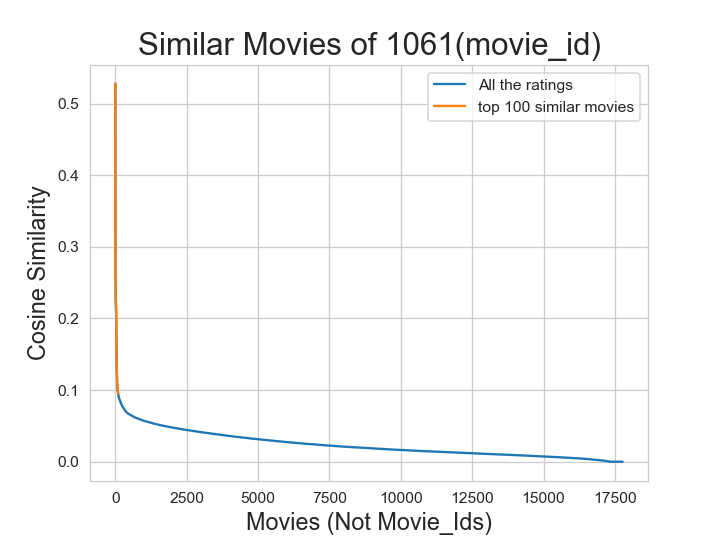

In [30]:
plt.plot(similarities[similar_indices], label='All the ratings')
plt.plot(similarities[similar_indices[:100]], label='top 100 similar movies')
plt.title("Similar Movies of {}(movie_id)".format(mv_id), fontsize=20)
plt.xlabel("Movies (Not Movie_Ids)", fontsize=15)
plt.ylabel("Cosine Similarity",fontsize=15)
plt.legend()
plt.show()
#plt.savefig("img/similar-movies-for-movieId-1061.png")

In [31]:
# Top 10 similar movies for choosed moive_id
movie_titles.loc[similar_indices[:10]]

,year_of_release,title
movie_id,,
12524,2004.0,Spider-Man: The Return of the Green Goblin
2279,2002.0,Spider-Man: The Ultimate Villain Showdown
13274,1996.0,Daredevil vs. Spiderman
1231,1999.0,Batman Beyond: Tech Wars / Disappearing Inque
14184,1967.0,Spider-Man: The '67 Classic Collection
2912,2003.0,Spider-Man: The New Animated Series: Season 1
14017,1999.0,Batman Beyond: School Dayz / Spellbound
11088,1992.0,Adventures of Batman & Robin: The Joker/Fire &...
4342,1992.0,Batman: The Animated Series: Out of the Shadows


### This same approach could be applied for **user-user** similarity too, then I could get top 10 etc similar users

In [32]:
def get_watched_movies(user_id, df):
    # Filter DataFrame to get rows corresponding to the specified user
    user_movies_df = df[df['user'] == user_id]
    # Get the list of movies watched by the user
    watched_movies = user_movies_df['movie'].tolist()
    return watched_movies

# Example usage:
target_user_id = 510180  # user to which we are recommending top 10 movies
watched_movies = get_watched_movies(target_user_id, train_df)
print("Movies already watched by user {}: {}".format(target_user_id, watched_movies))
  

Movies already watched by user 510180: [3870, 8357, 12473, 12470, 5571, 1367, 10774, 3730, 15105, 9798, 10341, 8651, 8079, 17764, 2866, 12818, 5625, 11313, 1798, 11234, 16465, 9392, 15057, 14660, 15894, 6615, 9003, 17064, 11080, 5474, 3421, 6902, 2478, 16182, 11612, 14455, 15336, 2948, 11259, 9536, 14869, 10832, 607, 15698, 15940, 13651, 7617, 550, 4883, 11638, 11005, 2518, 1314, 6971, 4912, 15922, 13622, 15421, 1421, 8773, 11888, 12317, 15674, 5237, 14610, 15466, 9785, 15813, 6336, 13058, 15472, 14403, 9189, 2622, 6240, 12160, 1324, 4870, 14624, 11490, 15455, 16668, 12926, 3113, 13705, 15875, 6574, 9432, 1035, 6158, 599, 3439, 12003, 12633, 432, 4248, 9635, 13748, 17625, 5477, 13216, 3563, 14858, 13248, 7624, 4736, 2174, 3617, 4402, 8317, 6266, 8840, 674, 8596, 13593, 2851, 4031, 16605, 3168, 4612, 10392, 5882, 2953, 6797, 8467, 10872, 11544, 12435, 17709, 3535, 4214, 4862, 13195, 2876, 14928, 7399, 833, 14856, 1027, 4824, 14109, 5775, 7055, 12309, 17616, 5845, 10375, 5402, 1615, 7397

In [33]:
from sklearn.metrics.pairwise import cosine_similarity

def get_similar_users(target_user_id, train_sparse_matrix, top_n):
    # Calculate cosine similarity between the target user and all other users
    similarity_scores = cosine_similarity(train_sparse_matrix[target_user_id], train_sparse_matrix).ravel()
    
    # Sort the similarity scores in descending order and get the indices of top similar users
    similar_users_indices = similarity_scores.argsort()[::-1][1:top_n+1]
    
    return similar_users_indices


In [34]:
target_user_id = 510180  # ID of the targeted user
similar_users_indices = get_similar_users(target_user_id, train_sparse_matrix, top_n=10)
print("Top similar users for user", target_user_id, ":", similar_users_indices)

Top similar users for user 510180 : [2070820 1912012   15191  829101  443193 1791707  113369  383858 1797525
 1413561]


### Combining both user-user and movie-movie collaborative filtering via Machine Learning

In [35]:
def get_sample_sparse_matrix(sparse_matrix, no_users, no_movies, path, verbose = True):
    """
        It will get it from the ''path'' if it is present  or It will create 
        and store the sampled sparse matrix in the path specified.
    """

    # get (row, col) and (rating) tuple from sparse_matrix...
    row_ind, col_ind, ratings = sparse.find(sparse_matrix)
    users = np.unique(row_ind)
    movies = np.unique(col_ind)

    print("Original Matrix : (users, movies) -- ({} {})".format(len(users), len(movies)))
    print("Original Matrix : Ratings -- {}\n".format(len(ratings)))

    # It just to make sure to get same sample everytime we run this program..
    # and pick without replacement....
    np.random.seed(15)
    sample_users = np.random.choice(users, no_users, replace=False)
    sample_movies = np.random.choice(movies, no_movies, replace=False)
    # get the boolean mask or these sampled_items in originl row/col_inds..
    mask = np.logical_and( np.isin(row_ind, sample_users),
                      np.isin(col_ind, sample_movies) )
    
    sample_sparse_matrix = sparse.csr_matrix((ratings[mask], (row_ind[mask], col_ind[mask])),
                                             shape=(max(sample_users)+1, max(sample_movies)+1))

    if verbose:
        print("Sampled Matrix : (users, movies) -- ({} {})".format(len(sample_users), len(sample_movies)))
        print("Sampled Matrix : Ratings --", format(ratings[mask].shape[0]))

    print('Saving it into pwd for furthur operations...')
    
    sparse.save_npz(path, sample_sparse_matrix)
    if verbose:
            print('Done.')
    
    return sample_sparse_matrix

### Creating Sample Train data from train_df

In [36]:
start = datetime.now()
path = "sample/small/sample_train_sparse_matrix.npz"
if os.path.isfile(path):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    sample_train_sparse_matrix = sparse.load_npz(path)
    print("DONE.")
else: 
    # get 8k users and 0.8k movies from available data 
    print("It is not present in pwd...")
    sample_train_sparse_matrix = get_sample_sparse_matrix(train_sparse_matrix, no_users=8000, no_movies=800,
                                             path = path)

print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE.
0:00:00.102024


### Creating Sample Test Data from test_df

In [37]:
start = datetime.now()

path = "sample/small/sample_test_sparse_matrix.npz"
if os.path.isfile(path):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    sample_test_sparse_matrix = sparse.load_npz(path)
    print("DONE.")
else:
    # get 4k users and 400 movies from available data 
    print("It is not present in pwd...")
    sample_test_sparse_matrix = get_sample_sparse_matrix(test_sparse_matrix, no_users=4000, no_movies=400,
                                                 path = "sample/small/sample_test_sparse_matrix.npz")
print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE.
0:00:00.029227


#### Finding Global Average of all movie ratings, Average rating per User, and Average rating per Movie (from sampled train)

In [38]:
sample_train_averages = dict()

In [39]:
# get the global average of ratings in our train set.
global_average = sample_train_sparse_matrix.sum()/sample_train_sparse_matrix.count_nonzero()
sample_train_averages['global'] = global_average
sample_train_averages['global']

3.6119795304186613

In [40]:
sample_train_averages['user'] = get_average_ratings(sample_train_sparse_matrix, of_users=True)
print('\nAverage rating of user 1179 :',sample_train_averages['user'][1179])


Average rating of user 1179 : 3.7142857142857144


In [41]:
sample_train_averages['movie'] =  get_average_ratings(sample_train_sparse_matrix, of_users=False)
print('\n AVerage rating of movie 6464 :',sample_train_averages['movie'][6464])


 AVerage rating of movie 6464 : 3.400396432111001


### Featurizing Data

In [42]:
print('No of ratings in Our Sampled train matrix is : {}\n'.format(sample_train_sparse_matrix.count_nonzero()))
print('No of ratings in Our Sampled test  matrix is : {}\n'.format(sample_test_sparse_matrix.count_nonzero()))

No of ratings in Our Sampled train matrix is : 78751

No of ratings in Our Sampled test  matrix is : 4530



####  Featurizing train data

In [43]:
# get users, movies and ratings from our samples train sparse matrix
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_train_sparse_matrix)

In [44]:
start = datetime.now()
if os.path.isfile('sample/small/reg_train.csv'):
    print("File already exists you don't have to prepare again..." )
else:
    print('preparing {} tuples for the dataset..\n'.format(len(sample_train_ratings)))
    with open('sample/small/reg_train.csv', mode='w') as reg_data_file:
        count = 0
        for (user, movie, rating)  in zip(sample_train_users, sample_train_movies, sample_train_ratings):
            st = datetime.now()
        #     print(user, movie)    
            #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            # compute the similar Users of the "user"        
            user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
            top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar users for this movie
            top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
            # we will make it's length "5" by adding movie averages to .
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
        #     print(top_sim_users_ratings, end=" ")    


            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            # compute the similar movies of the "movie"        
            movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
            top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar movie rated by this user..
            top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
            # we will make it's length "5" by adding user averages to.
            top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
        #     print(top_sim_movies_ratings, end=" : -- ")

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            row.append(user)
            row.append(movie)
            # Now add the other features to this data...
            row.append(sample_train_averages['global']) # first feature
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            # Avg_user rating
            row.append(sample_train_averages['user'][user])
            # Avg_movie rating
            row.append(sample_train_averages['movie'][movie])

            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%10000 == 0:
                # print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))


print(datetime.now() - start)

File already exists you don't have to prepare again...
0:00:00.001000


In [45]:
reg_train = pd.read_csv('sample/small/reg_train.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating'], header=None)
reg_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,692,14621,3.61198,2.0,4.0,5.0,5.0,5.0,4.0,4.0,4.0,4.0,4.0,4.000000,4.329095,4
1,1179,2239,3.61198,5.0,3.0,3.0,2.0,2.0,3.0,5.0,4.0,3.0,4.0,3.714286,2.909091,5
2,1179,4352,3.61198,4.0,3.0,2.0,3.0,3.0,4.0,4.0,3.0,4.0,5.0,3.714286,3.140845,3
3,1179,6464,3.61198,3.0,5.0,4.0,2.0,4.0,4.0,4.0,2.0,5.0,3.0,3.714286,3.400396,4
4,1179,6510,3.61198,4.0,4.0,3.0,4.0,3.0,5.0,4.0,4.0,3.0,4.0,3.714286,3.936614,4


- **GAvg**: Average Global Rating
- **UAvg**: User's average movie rating
- **MAvg**: Movie's average rating
- **Rating**: Rating given by the user to the movie
- **sur1, sur2, sur3, sur4, sur5**: Top 5 similar users who rated that movie
- **sm1r, smr2, smr3, smr4, smr5**: Top 5 similar movies rated by this user


In [46]:
reg_train.shape

(78751, 16)

#### Featurising test data

In [47]:
# get users, movies and ratings from the Sampled Test 
sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(sample_test_sparse_matrix)

In [48]:
global_average = sample_test_sparse_matrix.sum()/sample_test_sparse_matrix.count_nonzero()
sample_train_averages['global'] = global_average
sample_train_averages['global']

3.5304635761589402

In [49]:
start = datetime.now()

if os.path.isfile('sample/small/reg_test.csv'):
    print("It is already created...")
else:

    print('preparing {} tuples for the dataset..\n'.format(len(sample_test_ratings)))
    with open('sample/small/reg_test.csv', mode='w') as reg_data_file:
        count = 0 
        for (user, movie, rating)  in zip(sample_test_users, sample_test_movies, sample_test_ratings):
            st = datetime.now()

        #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            #print(user, movie)
            try:
                # compute the similar Users of the "user"        
                user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
                top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar users for this movie
                top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
                # we will make it's length "5" by adding movie averages to .
                top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
                # print(top_sim_users_ratings, end="--")

            except (IndexError, KeyError):
                # It is a new User or new Movie or there are no ratings for given user for top similar movies...
                ########## Cold STart Problem ##########
                top_sim_users_ratings.extend([sample_train_averages['global']]*(5 - len(top_sim_users_ratings)))
                #print(top_sim_users_ratings)
            except:
                print(user, movie)
                # we just want KeyErrors to be resolved. Not every Exception...
                raise



            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            try:
                # compute the similar movies of the "movie"        
                movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
                top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar movie rated by this user..
                top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
                # we will make it's length "5" by adding user averages to.
                top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
                #print(top_sim_movies_ratings)
            except (IndexError, KeyError):
                #print(top_sim_movies_ratings, end=" : -- ")
                top_sim_movies_ratings.extend([sample_train_averages['global']]*(5-len(top_sim_movies_ratings)))
                #print(top_sim_movies_ratings)
            except :
                raise

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            # add usser and movie name first
            row.append(user)
            row.append(movie)
            row.append(sample_train_averages['global']) # first feature
            #print(row)
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            #print(row)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            #print(row)
            # Avg_user rating
            try:
                row.append(sample_train_averages['user'][user])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            #print(row)
            # Avg_movie rating
            try:
                row.append(sample_train_averages['movie'][movie])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            #print(row)
            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            #print(row)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            #print(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%1000 == 0:
                #print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))
    print("",datetime.now() - start)  

It is already created...


In [50]:
reg_test_df = pd.read_csv('sample/small/reg_test.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5',
                                                          'smr1', 'smr2', 'smr3', 'smr4', 'smr5',
                                                          'UAvg', 'MAvg', 'rating'], header=None)
reg_test_df.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,7,13072,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,5
1,126,3418,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,5
2,268,11740,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,5
3,1809,705,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,4
4,1809,1140,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3


### Surprise model
Ref : http://surprise.readthedocs.io/en/stable/getting_started.html#load-dom-dataframe-py

In [51]:
pip install scikit-surprise


In [52]:
from surprise import Reader, Dataset

In [53]:
reader = Reader(rating_scale=(1,5))

# create the traindata from the dataframe...
train_data = Dataset.load_from_df(reg_train[['user', 'movie', 'rating']], reader)

# build the trainset from traindata.., It is of dataset format from surprise library..
trainset = train_data.build_full_trainset() 

In [54]:
testset = list(zip(reg_test_df.user.values, reg_test_df.movie.values, reg_test_df.rating.values))
testset[:10]

[(7, 13072, 5),
 (126, 3418, 5),
 (268, 11740, 5),
 (1809, 705, 4),
 (1809, 1140, 3),
 (1809, 2533, 3),
 (1809, 3418, 3),
 (1809, 4011, 4),
 (1809, 6849, 5),
 (1809, 11740, 4)]

In [57]:
len(testset)

4530

### Applying ML models 
I would be using ML models and storing their MAPE and RMSE in following

In [58]:
models_evaluation_train = dict()
models_evaluation_test = dict()

models_evaluation_train, models_evaluation_test

({}, {})

#### XgBoost

In [59]:
# to get rmse and mape given actual and predicted ratings..
def get_error_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean([ (y_true[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
    mape = np.mean(np.abs( (y_true - y_pred)/y_true )) * 100
    return rmse, mape

def run_xgboost(algo,  x_train, y_train, x_test, y_test, verbose=True):
    """
    It will return train_results and test_results
    """
    
    # dictionaries for storing train and test results
    train_results = dict()
    test_results = dict()
    
    
    # fit the model
    print('Training the model..')
    start =datetime.now()
    algo.fit(x_train, y_train, eval_metric = 'rmse')
    print('Done. Time taken : {}\n'.format(datetime.now()-start))
    print('Done \n')

    # from the trained model, get the predictions....
    print('Evaluating the model with TRAIN data...')
    start =datetime.now()
    y_train_pred = algo.predict(x_train)
    # get the rmse and mape of train data...
    rmse_train, mape_train = get_error_metrics(y_train.values, y_train_pred)
    
    # store the results in train_results dictionary..
    train_results = {'rmse': rmse_train,
                    'mape' : mape_train,
                    'predictions' : y_train_pred}
    
  
    # get the test data predictions and compute rmse and mape
    print('Evaluating Test data')
    y_test_pred = algo.predict(x_test) 
    rmse_test, mape_test = get_error_metrics(y_true=y_test.values, y_pred=y_test_pred)
    # store them in our test results dictionary.
    test_results = {'rmse': rmse_test,
                    'mape' : mape_test,
                    'predictions':y_test_pred}
    if verbose:
        print('-'*15)
        print('\nTEST DATA')
        print('-'*15)
        print('RMSE : ', rmse_test)
        print('MAPE : ', mape_test)
        
    # return these train and test results...
    return train_results, test_results

#### Surprise Model

In [60]:
# it is just to makesure that all of our algorithms should produce same results
# everytime it run

my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)


def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    pred = np.array([pred.est for pred in predictions])
    
    return actual, pred


def get_errors(predictions, print_them=False):

    actual, pred = get_ratings(predictions)
    rmse = np.sqrt(np.mean((pred - actual)**2))
    mape = np.mean(np.abs(pred - actual)/actual)

    return rmse, mape*100


def run_surprise(algo, trainset, testset, verbose=True): 
    '''
        return train_dict, test_dict
    
        It returns two dictionaries, one for train and the other is for test
        Each of them have 3 key-value pairs, which specify ''rmse'', ''mape'', and ''predicted ratings''.
    '''
    start = datetime.now()
    # dictionaries that stores metrics for train and test..
    train = dict()
    test = dict()
    
    # train the algorithm with the trainset
    st = datetime.now()
    print('Training the model...')
    algo.fit(trainset)
    print('Done. time taken : {} \n'.format(datetime.now()-st))
    
    # ---------------- Evaluating train data--------------------#
    st = datetime.now()
    print('Evaluating the model with train data..')
    # get the train predictions (list of prediction class inside Surprise)
    train_preds = algo.test(trainset.build_testset())
    # get predicted ratings from the train predictions..
    train_actual_ratings, train_pred_ratings = get_ratings(train_preds)
    # get ''rmse'' and ''mape'' from the train predictions.
    train_rmse, train_mape = get_errors(train_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Train Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(train_rmse, train_mape))
    
    #store them in the train dictionary
    if verbose:
        print('adding train results in the dictionary..')
    train['rmse'] = train_rmse
    train['mape'] = train_mape
    train['predictions'] = train_pred_ratings
    
    #------------ Evaluating Test data---------------#
    st = datetime.now()
    print('\nEvaluating for test data...')
    # get the predictions( list of prediction classes) of test data
    test_preds = algo.test(testset)
    # get the predicted ratings from the list of predictions
    test_actual_ratings, test_pred_ratings = get_ratings(test_preds)
    # get error metrics from the predicted and actual ratings
    test_rmse, test_mape = get_errors(test_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Test Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(test_rmse, test_mape))
    # store them in test dictionary
    if verbose:
        print('storing the test results in test dictionary...')
    test['rmse'] = test_rmse
    test['mape'] = test_mape
    test['predictions'] = test_pred_ratings
    
    print('\n'+'-'*45)
    print('Total time taken to run this algorithm :', datetime.now() - start)
    
    # return two dictionaries train and test
    return train, test

#### XGBoost with 13 features

In [61]:
import xgboost as xgb

In [62]:
# prepare Train data
x_train = reg_train.drop(['user','movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

Before running XGBRegressor, we will tune hyperparameter using gridsearch cross validation.

In [63]:
parameters = {'max_depth':[1,2,3],
              'learning_rate':[0.001,0.01,0.1],
              'n_estimators':[100,300,500,700,900,1100,1300]} 

In [64]:
start = datetime.now()

# Initialize Our first XGBoost model
first_xgb = xgb.XGBRegressor(nthread=-1)

# Perform cross validation 
gscv = GridSearchCV(first_xgb,
                    param_grid = parameters,
                    scoring="neg_mean_squared_error",
                    cv = TimeSeriesSplit(n_splits=5),
                    n_jobs = -1,
                    verbose = 1)
gscv_result = gscv.fit(x_train, y_train)

# Summarize results
print("Best: %f using %s" % (gscv_result.best_score_, gscv_result.best_params_))
means = gscv_result.cv_results_['mean_test_score']
stds = gscv_result.cv_results_['std_test_score']
params = gscv_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))   
    
print("\nTime Taken: ",start - datetime.now())

Fitting 5 folds for each of 63 candidates, totalling 315 fits
Best: -0.708814 using {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
-9.025653 (0.086354) with: {'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 100}
-6.370065 (0.065370) with: {'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 300}
-4.586112 (0.049803) with: {'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 500}
-3.384751 (0.038173) with: {'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 700}
-2.574056 (0.028906) with: {'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 900}
-2.026047 (0.022615) with: {'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 1100}
-1.654525 (0.019059) with: {'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 1300}
-9.007607 (0.086782) with: {'learning_rate': 0.001, 'max_depth': 2, 'n_estimators': 100}
-6.326420 (0.062685) with: {'learning_rate': 0.001, 'max_depth': 2, 'n_estimators': 300}
-4.525044 (0.045065) with: {'learning_rate': 0.001, '

In [65]:
# Create new instance of XGBRegressor with tuned hyperparameters
first_xgb = xgb.XGBRegressor(max_depth=3,learning_rate = 0.1,n_estimators=500,nthread=-1)
first_xgb

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, nthread=-1, num_parallel_tree=None,
             predictor=None, ...)

Training the model..


C:\ana py\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


Done. Time taken : 0:00:03.618886

Done 

Evaluating the model with TRAIN data...
Evaluating Test data
---------------

TEST DATA
---------------
RMSE :  1.0869258296911568
MAPE :  35.00388531276107


<IPython.core.display.Javascript object>


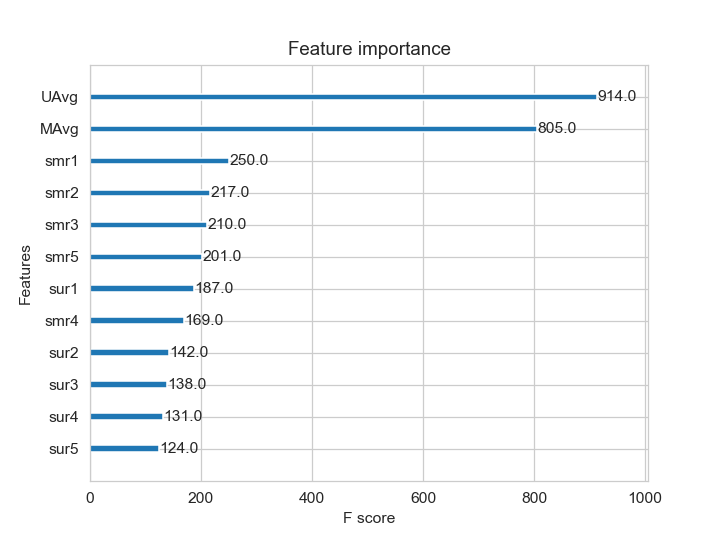

In [66]:
train_results, test_results = run_xgboost(first_xgb, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['first_algo'] = train_results
models_evaluation_test['first_algo'] = test_results

xgb.plot_importance(first_xgb)
plt.show()
#plt.savefig("sample/small/img/feature-importance-xgboost.png")

#### Suprise BaselineModel

In [68]:
from surprise import BaselineOnly 

In [69]:
# Instantiate BaselineOnly
bsl_options = {'method': 'sgd',
               'reg':0.01,
               'learning_rate': 0.001,
               'n_epochs':120
               }
bsl_algo = BaselineOnly(bsl_options=bsl_options)
bsl_algo

In [70]:
%%time

# run this algorithm.., It will return the train and test results..
bsl_train_results, bsl_test_results = run_surprise(bsl_algo, trainset, testset, verbose=True)


# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['bsl_algo'] = bsl_train_results 
models_evaluation_test['bsl_algo'] = bsl_test_results

Training the model...
Estimating biases using sgd...
Done. time taken : 0:00:00.876828 

Evaluating the model with train data..
time taken : 0:00:00.806888
---------------
Train Data
---------------
RMSE : 0.8828766422875534

MAPE : 26.93089077683406

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.022998
---------------
Test Data
---------------
RMSE : 1.0822513101982842

MAPE : 36.634142696886315

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:01.706714
Wall time: 1.71 s


## XGBoost with initial 13 features + Surprise Baseline predictor

updating train data

In [71]:
# add our baseline_predicted value as our feature..
reg_train['bslpr'] = models_evaluation_train['bsl_algo']['predictions']
reg_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,692,14621,3.61198,2.0,4.0,5.0,5.0,5.0,4.0,4.0,4.0,4.0,4.0,4.000000,4.329095,4,4.299739
1,1179,2239,3.61198,5.0,3.0,3.0,2.0,2.0,3.0,5.0,4.0,3.0,4.0,3.714286,2.909091,5,3.294208
2,1179,4352,3.61198,4.0,3.0,2.0,3.0,3.0,4.0,4.0,3.0,4.0,5.0,3.714286,3.140845,3,3.273046
3,1179,6464,3.61198,3.0,5.0,4.0,2.0,4.0,4.0,4.0,2.0,5.0,3.0,3.714286,3.400396,4,3.537082
4,1179,6510,3.61198,4.0,4.0,3.0,4.0,3.0,5.0,4.0,4.0,3.0,4.0,3.714286,3.936614,4,4.021263


updating test data

In [72]:
# add that baseline predicted ratings with Surprise to the test data as well
reg_test_df['bslpr']  = models_evaluation_test['bsl_algo']['predictions']
reg_test_df.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,7,13072,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,5,3.61198
1,126,3418,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,5,3.61198
2,268,11740,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,5,3.61198
3,1809,705,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,4,3.61198
4,1809,1140,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3.530464,3,3.61198


In [73]:
# prepare train data
x_train = reg_train.drop(['user', 'movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

Before running XGBRegressor, we will tune hyperparameter using gridsearch cross validation.

In [74]:
start = datetime.now()

# Initialize Our first XGBoost model
xgb = xgb.XGBRegressor(nthread=-1)

# Perform cross validation 
gscv = GridSearchCV(xgb,
                    param_grid = parameters,
                    scoring="neg_mean_squared_error",
                    cv = TimeSeriesSplit(n_splits=5),
                    n_jobs = -1,
                    verbose = 1)
gscv_result = gscv.fit(x_train, y_train)

# Summarize results
print("Best: %f using %s" % (gscv_result.best_score_, gscv_result.best_params_))
print()
means = gscv_result.cv_results_['mean_test_score']
stds = gscv_result.cv_results_['std_test_score']
params = gscv_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))  

print("\nTime Taken: ",datetime.now() -start)

Fitting 5 folds for each of 63 candidates, totalling 315 fits
Best: -0.699004 using {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}

-9.008878 (0.085110) with: {'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 100}
-6.329089 (0.060296) with: {'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 300}
-4.529086 (0.042579) with: {'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 500}
-3.318721 (0.030264) with: {'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 700}
-2.503446 (0.022677) with: {'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 900}
-1.953504 (0.019290) with: {'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 1100}
-1.582040 (0.018886) with: {'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 1300}
-8.993858 (0.081585) with: {'learning_rate': 0.001, 'max_depth': 2, 'n_estimators': 100}
-6.292672 (0.052440) with: {'learning_rate': 0.001, 'max_depth': 2, 'n_estimators': 300}
-4.479969 (0.034554) with: {'learning_rate': 0.001, 

In [ ]:
# Create new instance of XGBRegressor with tuned hyperparameters
xgb_bsl = xgb.XGBRegressor(max_depth=3,learning_rate = 0.01,n_estimators=1300,nthread=-1)
xgb_bsl

In [ ]:
# Run XGBRegressor
train_results, test_results = run_xgboost(xgb_bsl, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_bsl'] = train_results
models_evaluation_test['xgb_bsl'] = test_results

xgb.plot_importance(xgb_bsl)
plt.show()
#plt.savefig("sample/small/img/feature-importance-xgboost+surprise.png")

## Surprise KNNBaseline predictor

In [ ]:
from surprise import KNNBaseline

Surprise KNNBaseline with user user similarities

In [ ]:
# we specify , how to compute similarities and what to consider with sim_options to our algorithm
sim_options = {'user_based' : True,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'} 

knn_bsl_u = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)
knn_bsl_u_train_results, knn_bsl_u_test_results = run_surprise(knn_bsl_u, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['knn_bsl_u'] = knn_bsl_u_train_results 
models_evaluation_test['knn_bsl_u'] = knn_bsl_u_test_results

Surprise KNNBaseline with movie movie similarities

In [ ]:
# I specified , how to compute similarities and what to consider with sim_options to our algorithm

# 'user_based' : Fals => this considers the similarities of movies instead of users

sim_options = {'user_based' : False,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'}


knn_bsl_m = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)

knn_bsl_m_train_results, knn_bsl_m_test_results = run_surprise(knn_bsl_m, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['knn_bsl_m'] = knn_bsl_m_train_results 
models_evaluation_test['knn_bsl_m'] = knn_bsl_m_test_results

## XGBoost with initial 13 features + Surprise Baseline predictor + KNNBaseline predictor

- First I will run XGBoost with predictions from both KNN's ( that uses User_User and Item_Item similarities along with our previous features)
- Then I will run XGBoost with just predictions form both knn models and preditions from our baseline model.

preparing train data

In [ ]:
# add the predicted values from both knns to this dataframe
reg_train['knn_bsl_u'] = models_evaluation_train['knn_bsl_u']['predictions']
reg_train['knn_bsl_m'] = models_evaluation_train['knn_bsl_m']['predictions']

reg_train.head()

preparing test data

In [ ]:
reg_test_df['knn_bsl_u'] = models_evaluation_test['knn_bsl_u']['predictions']
reg_test_df['knn_bsl_m'] = models_evaluation_test['knn_bsl_m']['predictions']

reg_test_df.head()

In [ ]:
# prepare the train data....
x_train = reg_train.drop(['user', 'movie', 'rating'], axis=1)
y_train = reg_train['rating']

# prepare the train data....
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

Before running XGBRegressor, we will tune hyperparameter using gridsearch cross validation.

In [ ]:
start = datetime.now()

# Initialize Our first XGBoost model
model = xgb.XGBRegressor(nthread=-1)

# Perform cross validation 
gscv = GridSearchCV(model,
                    param_grid = parameters,
                    scoring="neg_mean_squared_error",
                    cv = TimeSeriesSplit(n_splits=5),
                    n_jobs = -1,
                    verbose = 1)
gscv_result = gscv.fit(x_train, y_train)

# Summarize results
print("Best: %f using %s" % (gscv_result.best_score_, gscv_result.best_params_))
print()
means = gscv_result.cv_results_['mean_test_score']
stds = gscv_result.cv_results_['std_test_score']
params = gscv_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))  

print("\nTime Taken: ",datetime.now() - start)

In [ ]:
# Create new instance of XGBRegressor with tuned hyperparameters
xgb_knn_bsl = xgb.XGBRegressor(max_depth=3,learning_rate = 0.1,n_estimators=300,nthread=-1)
xgb_knn_bsl

In [ ]:
train_results, test_results = run_xgboost(xgb_knn_bsl, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_knn_bsl'] = train_results
models_evaluation_test['xgb_knn_bsl'] = test_results


xgb.plot_importance(xgb_knn_bsl)
plt.show()
#plt.savefig("sample/small/img/feature-importance-xgb+bsl+knn.png")

## Matrix Factorization Techniques

### SVD

In [ ]:
from surprise import SVD

In [ ]:
# initiallize the model
svd = SVD(n_factors=100, biased=True, random_state=30, verbose=True)
svd_train_results, svd_test_results = run_surprise(svd, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svd'] = svd_train_results 
models_evaluation_test['svd'] = svd_test_results

### SVD Matrix Factorization with implicit feedback from user ( user rated movies )

In [ ]:
from surprise import SVDpp

In [ ]:
# initiallize the model
svdpp = SVDpp(n_factors=50, random_state=30, verbose=True)
svdpp_train_results, svdpp_test_results = run_surprise(svdpp, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svdpp'] = svdpp_train_results 
models_evaluation_test['svdpp'] = svdpp_test_results

In [ ]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(reg_train[['user', 'movie', 'rating']], reader)

trainset = data.build_full_trainset()

# Choose the user and movie for which you want recommendations
user_id = 2281810
movie_id = 14410

# Get a list of all movie IDs
all_movie_ids = list(trainset.all_items())

# Remove the movie the user has already watched from the list (if present)
try:
    all_movie_ids.remove(movie_id)
except ValueError:
    pass

# Predict ratings for all movies for the given user via svd
predicted_ratings = [svd.predict(user_id, movie_id).est for movie_id in all_movie_ids]

# Combine movie IDs with predicted ratings
movie_ratings = list(zip(all_movie_ids, predicted_ratings))

# Sort the movies based on predicted ratings in descending order
sorted_movie_ratings = sorted(movie_ratings, key=lambda x: x[1], reverse=True)


top_5_recommendations = sorted_movie_ratings[:10]


for movie_id, predicted_rating in top_5_recommendations:
    print("Movie ID:", movie_id, "| Predicted Rating:", predicted_rating)


Top 10 movies recommended by this method and top 10 movies recommended earlier will be different, because:
- Here, I used small sample / number of user, movie tuples
- And above movie-movie predictor was based on m_m_sim_sparse.npz which was made by considering every user, movie tuples

## XgBoost with 13 features + Surprise Baseline + Surprise KNNbaseline + MF Techniques

Preparing Train data

In [ ]:
# add the predicted values from both knns to this dataframe
reg_train['svd'] = models_evaluation_train['svd']['predictions']
reg_train['svdpp'] = models_evaluation_train['svdpp']['predictions']

reg_train.head() 

Preparing Test data

In [ ]:
reg_test_df['svd'] = models_evaluation_test['svd']['predictions']
reg_test_df['svdpp'] = models_evaluation_test['svdpp']['predictions']

reg_test_df.head()

In [ ]:
# prepare x_train and y_train
x_train = reg_train.drop(['user', 'movie', 'rating',], axis=1)
y_train = reg_train['rating']

# prepare test data
x_test = reg_test_df.drop(['user', 'movie', 'rating'], axis=1)
y_test = reg_test_df['rating']

Before running XGBRegressor, we will tune hyperparameter using gridsearch cross validation.

In [ ]:
start = datetime.now()

# Initialize Our first XGBoost model
model = xgb.XGBRegressor(nthread=-1)

# Perform cross validation 
gscv = GridSearchCV(model,
                    param_grid = parameters,
                    scoring="neg_mean_squared_error",
                    cv = TimeSeriesSplit(n_splits=5),
                    n_jobs = -1,
                    verbose = 1)
gscv_result = gscv.fit(x_train, y_train)

# Summarize results
print("Best: %f using %s" % (gscv_result.best_score_, gscv_result.best_params_))
print()
means = gscv_result.cv_results_['mean_test_score']
stds = gscv_result.cv_results_['std_test_score']
params = gscv_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))  

print("\nTime Taken: ",datetime.now() - start)

In [ ]:
# Create new instance of XGBRegressor with tuned hyperparameters
xgb_final = xgb.XGBRegressor(max_depth=3,learning_rate = 0.01,n_estimators=1300,nthread=-1)
xgb_final

In [ ]:
train_results, test_results = run_xgboost(xgb_final, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_final'] = train_results
models_evaluation_test['xgb_final'] = test_results


xgb.plot_importance(xgb_final)
plt.show()
#plt.savefig("sample/small/img/feature-importance-xgb+knn+bsl+svd.png")

## XgBoost with Surprise Baseline + Surprise KNNbaseline + MF Techniques

In [ ]:
# prepare train data
x_train = reg_train[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_train = reg_train['rating']

# test data
x_test = reg_test_df[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_test = reg_test_df['rating']

Before running XGBRegressor, we will tune hyperparameter using gridsearch cross validation.

In [ ]:
start = datetime.now()

# Initialize Our first XGBoost model
model = xgb.XGBRegressor(nthread=-1)

# Perform cross validation 
gscv = GridSearchCV(model,
                    param_grid = parameters,
                    scoring="neg_mean_squared_error",
                    cv = TimeSeriesSplit(n_splits=5),
                    n_jobs = -1,
                    verbose = 1)
gscv_result = gscv.fit(x_train, y_train)

# Summarize results
print("Best: %f using %s" % (gscv_result.best_score_, gscv_result.best_params_))
print()
means = gscv_result.cv_results_['mean_test_score']
stds = gscv_result.cv_results_['std_test_score']
params = gscv_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))  

print("\nTime Taken: ",datetime.now() - start)

In [ ]:
# Create new instance of XGBRegressor with tuned hyperparameters
xgb_all_models = xgb.XGBRegressor(max_depth=1,learning_rate = 0.01,n_estimators=700,nthread=-1)
xgb_all_models

In [ ]:
train_results, test_results = run_xgboost(xgb_all_models, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_all_models'] = train_results
models_evaluation_test['xgb_all_models'] = test_results

xgb.plot_importance(xgb_all_models)
plt.show()
#plt.savefig("sample/small/img/feature-importance-xgb_with_bsl+knn+svd.png")

# Comparision between all

In [ ]:
# Saving our TEST_RESULTS into a dataframe to avoid running it again
pd.DataFrame(models_evaluation_test).to_csv('sample/small/models-rmse-comparison.csv')
models = pd.read_csv('sample/small/models-rmse-comparison.csv', index_col=0)
models.loc['rmse'].sort_values()

# Which is best method/model and Conclusion

- ### svd showed good result among all the models I tried.
- ### Due to high computational power and time, I have completed this case study on (8000,800) training dataset and (4000,400) testing dataset.
- ### Approach followed is as mentioned in [this](https://datajobs.com/data-science-repo/Recommender-Systems-%5BNetflix%5D.pdf) research paper
- ### Small decrease in 'RMSE' score is observed, but this can be drastically improved by using the whole dataset for modeling.(Not feasible at the moment)

# SOTA Comparison

### As per [this](https://datajobs.com/data-science-repo/Recommender-Systems-%5BNetflix%5D.pdf) research paper, the Netflix system achieves **RMSE = 0.9514** on the same dataset
### While the grand prize’s required accuracy is RMSE = 0.8563, and it was won by BigChaos solution with **RMSE=0.8567**

### I acheived minimum **RMSE = 1.0821912114098393** 